# Implement STICS on real OCT data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import DataProcessingOCT
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource

In [2]:
# load the data from the .npy file
image_timeseries = np.load("Meting_41_data.npy")

In [11]:
# set some parameters from the measurements
aqcuisition_time = 3.268
N_A_scans = 1024   # number of A scans per B scan
N_B_scans = 12 # number of b scans
M = 1024


b_scan_time = aqcuisition_time/N_B_scans
print("The B-scan time is: ",b_scan_time )

The B-scan time is:  0.2723333333333333


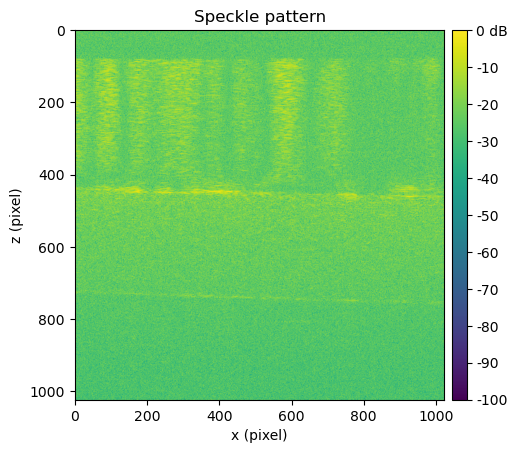

In [12]:
# create the average of the series and plot this
image_average = np.average(image_timeseries,2)
#print(image_timeseries[:,:,0])


fig1,ax=DataProcessingOCT.plot_Bscan_image(image_average,dBlevel=100,title='Speckle pattern')
plt.show()

In [7]:
# plot the 3D data

# get the real part
real_intensity = np.abs(image_timeseries)

# creating the 3D plot using the following parameters
time_slice = 0
min_z = 0
max_z = 512
min_x = 0
max_x = 512

# set the to be plotted 3D array
plot_data = real_intensity[min_z:max_z,min_x:max_x,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = np.arange(x_axis_points)
y_axis = np.arange(y_axis_points)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)


# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)

# Set ax labels
plt.xlabel("x position(pixel)")
plt.ylabel("z position(pixel)")
plt.title("Intensity of OCT signal at $t={}$".format(time_slice))

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

Error in callback <function _draw_all_if_interactive at 0x7fc127ff6680> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc128d6dcf0> (for post_execute):


KeyboardInterrupt: 

## Immobile population removal

In [13]:
# parameters for the heaviside function:
total_acquisition_time = b_scan_time*(N_B_scans-1)

# create the heaviside function:
H = np.zeros([int(M),N_A_scans,N_B_scans])

# check if frequency is higher than 1/T
for w in range(N_B_scans):
    if w>1/total_acquisition_time:
        H[:,:,w] = 1
    else:
        H[:,:,w] = 0.1e-19

# now implement the heaviside function on the image data in the fourier domain
intensity = np.fft.ifft(np.fft.fft(image_timeseries,axis=2)*H)

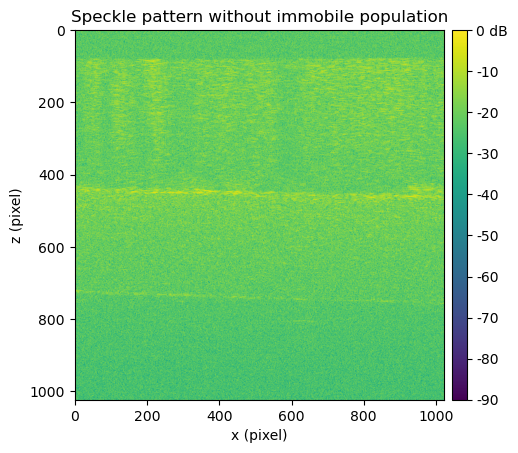

In [14]:
fig1,ax=DataProcessingOCT.plot_Bscan_image(intensity[:,:,0],dBlevel=90,title='Speckle pattern without immobile population')
plt.show()

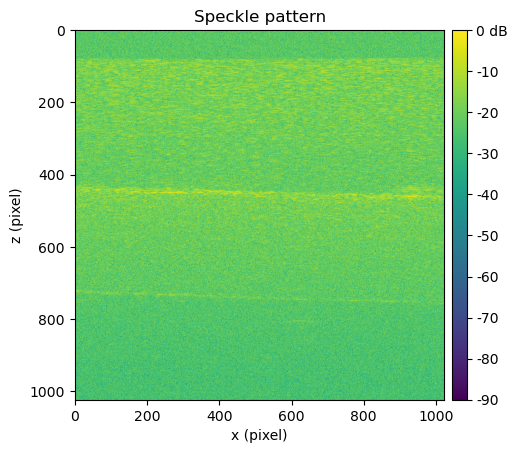

In [16]:
fig1,ax=DataProcessingOCT.plot_Bscan_image(image_timeseries[:,:,0],dBlevel=90,title='Speckle pattern')
plt.show()

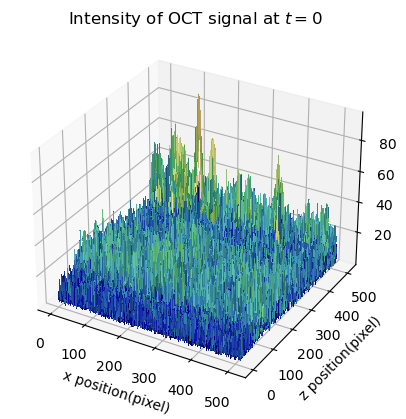

In [ ]:
# plot the 3D data

# get the real part
real_intensity = np.abs(intensity)

# creating the 3D plot using the following parameters
time_slice = 0
min_z = 0
max_z = 512
min_x = 0
max_x = 512

# set the to be plotted 3D array
plot_data = real_intensity[min_z:max_z,min_x:max_x,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = np.arange(min_x,max_x)
y_axis = np.arange(min_z,max_z)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)


# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)

# Set ax labels
plt.xlabel("x position(pixel)")
plt.ylabel("z position(pixel)")
plt.title("Intensity of OCT signal at $t={}$".format(time_slice))

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

## Apply STICS autocorrelation function

This takes a long time for correlation to be calculated and due to the flow speed being very high relative to the lag in pixels it is very unlikely that a flow speed can be measured using this technique.

In [27]:
# set correlation parameters
N_time_lags = 2
N_spacial_lags = 100 # should be an even number

# create real intensity similar to real OCT data
real_intensity = np.abs(intensity)

# retrieve maximum values
Z,X,T = real_intensity.shape

N = Z
M = Z

# create spacial lags array
spacial_lags = np.arange(-int(N_spacial_lags/2),int(N_spacial_lags/2))

# define correlation array 
correlation = np.zeros([N_spacial_lags,N_spacial_lags,N_time_lags])

# iterate over all lags
for m_index in range(N_spacial_lags):

    # set the m lag
    m = spacial_lags[m_index]

    for n_index in range(N_spacial_lags):

        # set the n lag
        n = spacial_lags[n_index]

        for delta_t in range(N_time_lags):

            # calculate the intensity fluctuations
            delta_i = (real_intensity - np.mean(real_intensity,axis=(0,1)))/np.mean(real_intensity,axis=(0,1))
            delta_i_shifted = np.roll(delta_i,(-m,-n,delta_t),axis=(0,1,2))[:Z-abs(m),:X-abs(n),:T-delta_t]
            delta_i = delta_i[:Z-abs(m),:X-abs(n),:T-delta_t]

            # calculate the correlations
            correlation[m_index,n_index,delta_t] = np.correlate(delta_i.flatten(),delta_i_shifted.flatten())




            

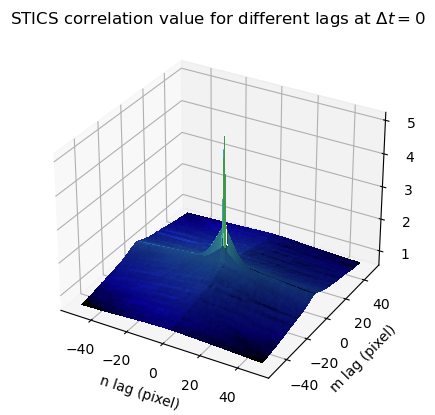

In [28]:
# plot the correlation data in 3D

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)
spacial_lags = np.arange(-int(N_spacial_lags/2),int(N_spacial_lags/2))

# creating the 3D plot
time_slice = 0

# set the to be plotted 3D array
plot_data = correlation[:,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = spacial_lags

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n lag (pixel)")
plt.ylabel("m lag (pixel)")
plt.title("STICS correlation value for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

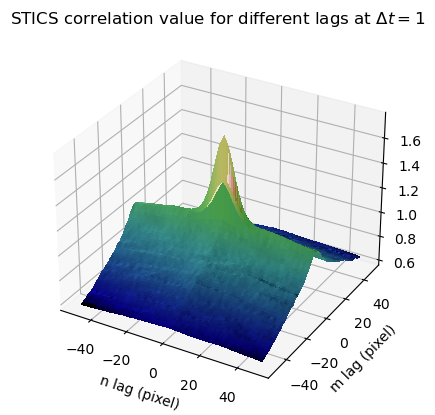

In [29]:
# plot the correlation data in 3D

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 1

# set the to be plotted 3D array
plot_data = correlation[:,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = spacial_lags

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n lag (pixel)")
plt.ylabel("m lag (pixel)")
plt.title("STICS correlation value for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

## Apply STICS without $z$ axis correlation

In [20]:
# set correlation parameters
N_time_lags = 2

# set pixel range for correlation
min_z = int(M/2)-150
max_z = int(M/2)+150

N_x_lags = max_z-min_z

real_intensity = np.abs(intensity)
Z,X,T = real_intensity.shape

correlation_no_z = np.zeros([len(real_intensity[:,0,0]),N_x_lags,N_time_lags])

spacial_lags = np.arange(-int(N_x_lags/2),int(N_x_lags/2))
print(spacial_lags)

# iterate over all z values and different lags
for z_index in range(min_z,max_z):
    
    real_intensity_z = real_intensity[z_index,:,:]

    for n_index in range(N_x_lags):
        for delta_t in range(N_time_lags):


            # set the lag
            n = spacial_lags[n_index]

            # calculate the intensity fluctuations
            delta_i = (real_intensity_z-np.mean(real_intensity_z,axis=0))/np.mean(real_intensity_z,axis=0)
            delta_i_shifted = np.roll(delta_i,(-n,delta_t),axis=(0,1))[:X-abs(n),:T-delta_t]
            delta_i = delta_i[:X-abs(n),:T-delta_t]

            # set the correlation value
            correlation_no_z[z_index,n_index,delta_t] = np.correlate(delta_i.flatten(),delta_i_shifted.flatten())

[-150 -149 -148 -147 -146 -145 -144 -143 -142 -141 -140 -139 -138 -137
 -136 -135 -134 -133 -132 -131 -130 -129 -128 -127 -126 -125 -124 -123
 -122 -121 -120 -119 -118 -117 -116 -115 -114 -113 -112 -111 -110 -109
 -108 -107 -106 -105 -104 -103 -102 -101 -100  -99  -98  -97  -96  -95
  -94  -93  -92  -91  -90  -89  -88  -87  -86  -85  -84  -83  -82  -81
  -80  -79  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69  -68  -67
  -66  -65  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55  -54  -53
  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41  -40  -39
  -38  -37  -36  -35  -34  -33  -32  -31  -30  -29  -28  -27  -26  -25
  -24  -23  -22  -21  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11
  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0    1    2    3
    4    5    6    7    8    9   10   11   12   13   14   15   16   17
   18   19   20   21   22   23   24   25   26   27   28   29   30   31
   32   33   34   35   36   37   38   39   40   41   42   43   44   45
   46 

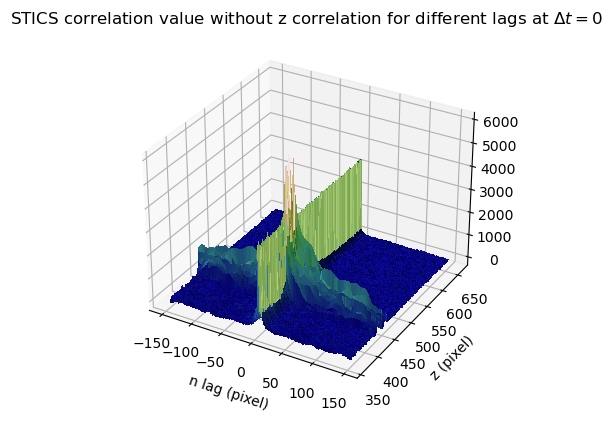

In [23]:
# plot the correlation data in 3D

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 0

# set the to be plotted 3D array
plot_data = correlation_no_z[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = np.arange(min_z,max_z)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n lag (pixel)")
plt.ylabel("z (pixel)")
plt.title("STICS correlation value without z correlation for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

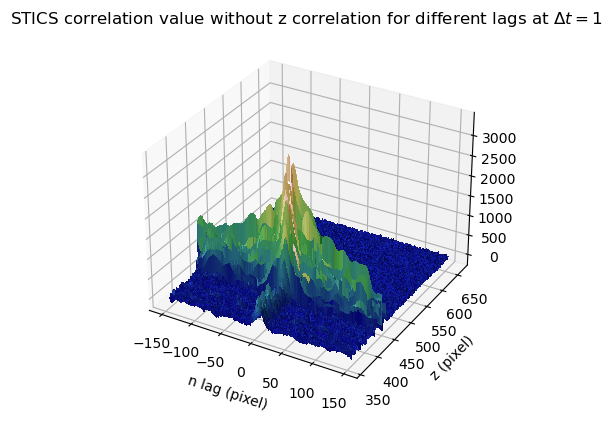

In [24]:
# plot the correlation data in 3D

# get the real part like data from measurements
real_intensity = np.abs(image_timeseries)

# creating the 3D plot
time_slice = 1

# set the to be plotted 3D array
plot_data = correlation_no_z[min_z:max_z,:,time_slice]

x_axis_points,y_axis_points = plot_data.shape

x_axis = spacial_lags
y_axis = np.arange(min_z,max_z)

x_axis,y_axis = np.meshgrid(x_axis,y_axis)
 
min = np.min(plot_data)
max = np.max(plot_data)

#y_axis = np.linspace(min,max,points)

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

# Set ax labels
plt.xlabel("n lag (pixel)")
plt.ylabel("z (pixel)")
plt.title("STICS correlation value without z correlation for different lags at $\Delta t={}$".format(time_slice))

ls = LightSource(270, 45)

# create colors and make plot
rgb = ls.shade(plot_data, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x_axis, y_axis, plot_data, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)